In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install Skorch

ERROR: Operation cancelled by user


In [39]:


#Comparison Between CNN and SVM with their application of the Fashion MNIST Dataset

#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report




In [40]:
#Path for the datasets
train_path ='/content/drive/MyDrive/neural_computing_coursework/fashion-mnist_train.csv'
test_path = '/content/drive/MyDrive/neural_computing_coursework/fashion-mnist_test.csv'
#loading of the datasets into dataframe
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [41]:
#training and test data is split and converted into numpy array for machine learing
X_train = train_data.drop('label', axis=1).values.astype(np.float32)
y_train = train_data['label'].values.astype(np.int64)
X_test = test_data.drop('label', axis=1).values.astype(np.float32)
y_test = test_data['label'].values.astype(np.int64)

In [42]:
#Scaling the pixel value to [0,1] range to bring all inputs on similar scale
X_train /= 255.0
X_test /= 255.0

In [43]:
X_train_flipped = np.array([np.fliplr(img.reshape(28, 28)).flatten() for img in X_train])
X_test_flipped = np.array([np.fliplr(img.reshape(28, 28)).flatten() for img in X_test])

In [44]:
#This code reshapes the flipped training and test datasets into 4D arrays for using in CNN
#labels however are extracted from the original data
#the features data from training and test dataset are further normalized
X_train_flipped = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype('float32')
y_train = train_data.iloc[:, 0].values
X_test_flipped = test_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype('float32')
y_test = test_data.iloc[:, 0].values

X_train_flipped /= 255.0
X_test_flipped /= 255.0


In [45]:
#CNN Base Model

In [46]:
#Implementation of CNN with 2 convolution layers with max pooling and 2 fully connected layers. Dropout is applied to the first fully connected
#layer for regularlisation and preventing overfitting
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [47]:
#Neural Network classifier is implemented with max '10' iterations along with Stochastic Gradient Descent optimizer and CrossEntropy loss since we have a
#multi-class classification task
net = NeuralNetClassifier(
    CNN,
    max_epochs=10,
    lr=0.01,
    optimizer=SGD,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'  # This determines the utilisation of either 'GPU' or 'CPU'.
)


In [48]:
cnn_base_model = joblib.load('/content/drive/MyDrive/neural_computing_coursework/trained_cnn_base_model.pkl')

# Perform testing using the loaded model
test_accuracy = cnn_base_model.score(X_test_flipped, y_test)
print(f"Test Accuracy using the loaded model: {test_accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/skorch/utils.py:568: DeviceWarning: Requested to load data to CUDA but no CUDA devices are available. Loading on device "cpu" instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skorch/net.py:2539: DeviceWarning: Setting self.device = cpu since the requested device (cuda) is not available.
  warnings.warn(


Test Accuracy using the loaded model: 84.42%


In [49]:
#CNN with hyper paramater optimisation

In [50]:
#CNN is implmented with number of filters in each of its layers and dropout rates making it more adaptable.
#padding is also implemented to prevent the information loss at the border of images
class CNN(nn.Module):
    def __init__(self, num_filters_1=32, num_filters_2=64, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(1, num_filters_1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, kernel_size=5, padding=2)

        #This line ensures that the input size of the fully connected layer matches with the size of the feautered maps.
        self.fc1 = nn.Linear(num_filters_2 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(dropout_rate)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, self.num_filters_2 * 7 * 7)  # Ensure the feature map size matches this calculation
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [51]:
#Neural Network classifier is implemented with Stochastic Gradient Descent optimizer and CrossEntropy loss since we have a
#multi-class classification task
cnn_model_architecture = NeuralNetClassifier(
    module=CNN,
    module__num_filters_1=32,
    module__num_filters_2=64,
    module__dropout_rate=0.5,
    max_epochs=10,
    lr=0.01,
    batch_size=64,
    optimizer=torch.optim.SGD,
    criterion=nn.CrossEntropyLoss,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [52]:
# Now you can load the model whenever you want to use it for testing
cnn_hyper_model = joblib.load('/content/drive/MyDrive/neural_computing_coursework/trained_cnn_hyper_model.pkl')

# Perform testing using the loaded model
test_accuracy = cnn_hyper_model.score(X_test_flipped, y_test)
print(f"Test Accuracy using the loaded model: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/skorch/utils.py:568: DeviceWarning: Requested to load data to CUDA but no CUDA devices are available. Loading on device "cpu" instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skorch/net.py:2539: DeviceWarning: Setting self.device = cpu since the requested device (cuda) is not available.
  warnings.warn(


Test Accuracy using the loaded model: 91.84%


In [53]:
# Predictions for training and test sets
y_train_pred = cnn_hyper_model.predict(X_train_flipped)
y_test_pred = cnn_hyper_model.predict(X_test_flipped)

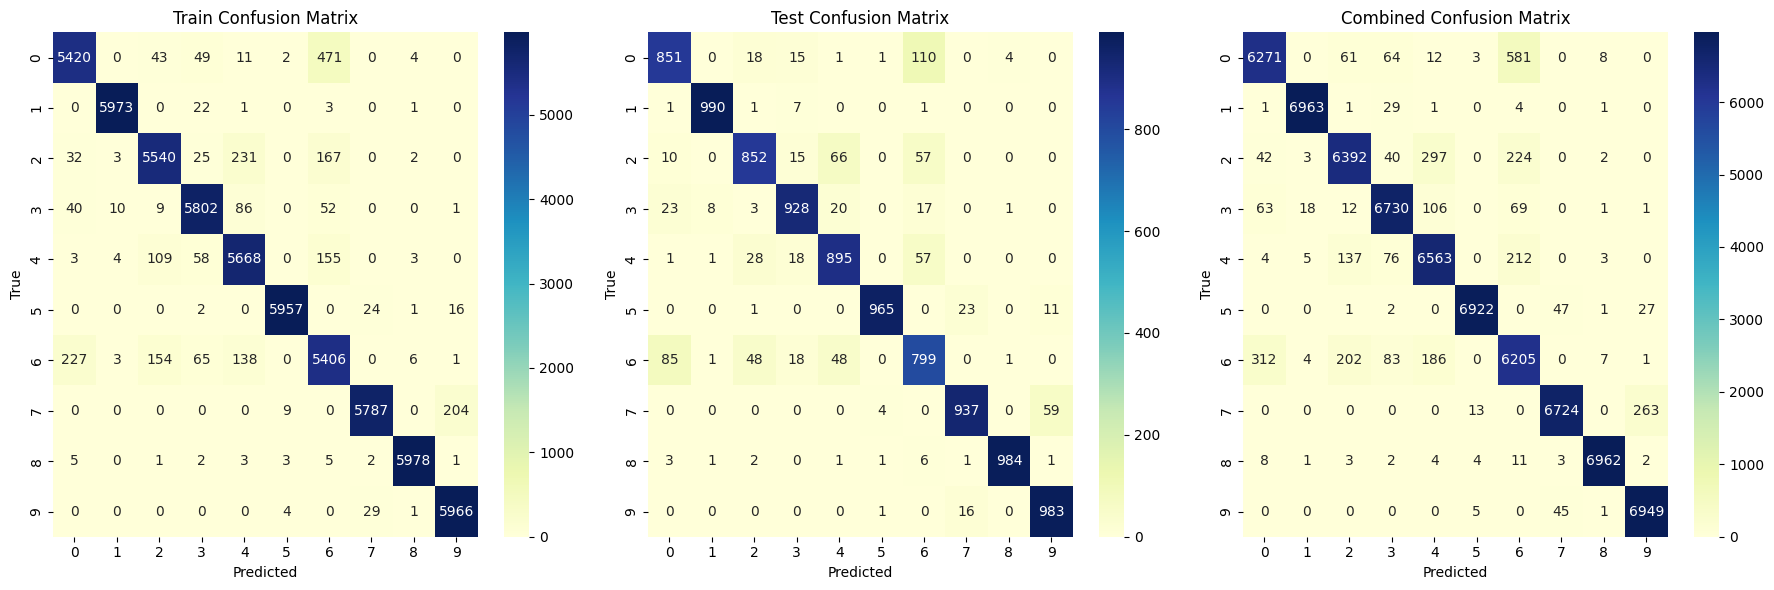

In [54]:
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Function to plot confusion matrix
def cnn_confusion_matrix(ax, cm, labels, title, cmap):
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

# Getting unique class labels
labels = np.unique(y_train)

# Creating confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred, labels=labels)
test_cm = confusion_matrix(y_test, y_test_pred, labels=labels)
all_cm = train_cm + test_cm

# Plotting confusion matrices side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

cnn_confusion_matrix(axs[0], train_cm, labels, title="Train Confusion Matrix", cmap="YlGnBu")
cnn_confusion_matrix(axs[1], test_cm, labels, title="Test Confusion Matrix", cmap="YlGnBu")
cnn_confusion_matrix(axs[2], all_cm, labels, title="Combined Confusion Matrix", cmap="YlGnBu")

plt.tight_layout()
plt.show()


In [55]:

# predicting training and test sets
y_pred = cnn_hyper_model.predict(X_test_flipped)

# Precision, Recall, and F1-Score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Classification Report
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(10)])

# Macro Average Metrics
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Micro Average Metrics
micro_precision = precision_score(y_test, y_pred, average='micro')
micro_recall = recall_score(y_test, y_pred, average='micro')
micro_f1 = f1_score(y_test, y_pred, average='micro')

# Print precision, recall, and F1-score for each class
print("Precision for each class:", precision)
print("\nRecall for each class:", recall)
print("\nF1-score for each class:", f1)


Precision for each class: [0.87371663 0.98901099 0.89401889 0.92707293 0.86808923 0.99279835
 0.76313276 0.95905834 0.99393939 0.93263757]

Recall for each class: [0.851 0.99  0.852 0.928 0.895 0.965 0.799 0.937 0.984 0.983]

F1-score for each class: [0.86220871 0.98950525 0.87250384 0.92753623 0.88133924 0.97870183
 0.78065462 0.94790086 0.98894472 0.95715677]


In [56]:
# Print classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.85      0.86      1000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.89      0.85      0.87      1000
     Class 3       0.93      0.93      0.93      1000
     Class 4       0.87      0.90      0.88      1000
     Class 5       0.99      0.96      0.98      1000
     Class 6       0.76      0.80      0.78      1000
     Class 7       0.96      0.94      0.95      1000
     Class 8       0.99      0.98      0.99      1000
     Class 9       0.93      0.98      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [57]:
# Print macro average metrics
print("Macro Average Precision:", macro_precision)
print("\nMacro Average Recall:", macro_recall)
print("\nMacro Average F1-score:", macro_f1)

Macro Average Precision: 0.9193475091140695

Macro Average Recall: 0.9184000000000001

Macro Average F1-score: 0.9186452067391457


In [58]:
# Print micro average metrics
print("Micro Average Precision:", micro_precision)
print("\nMicro Average Recall:", micro_recall)
print("\nMicro Average F1-score:", micro_f1)

Micro Average Precision: 0.9184

Micro Average Recall: 0.9184

Micro Average F1-score: 0.9184


In [59]:
#MLP Base Implementation

In [60]:
#features and labels from the training and test datasets are separeted nd normalised

X_test = test_data.iloc[:, 1:].values.astype('float32') / 255.0
y_test = test_data.iloc[:, 0].values.astype('int64')

In [61]:
#Multi layer perceptron of 3 hidden layers with ReLU activation is implemented.
#it returns output of size 10 which corresponds to the 10 output features of the dataset.
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # First hidden layer
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.fc3 = nn.Linear(256, 128)  # Third hidden layer
        self.fc4 = nn.Linear(128, 10)   # Output layer
        self.relu = nn.ReLU()

#forward pass is implemented to define the sequence of operations
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [62]:
#NeuralNetClassifier is defined encapsulating the MLP architecture along with training parameters and optimization.
# L2 regularisation for the optimiser is implemeented to prevent overfitting.
MLP_model = NeuralNetClassifier(
    MLP,
    max_epochs=20,
    lr=0.1,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    optimizer__weight_decay=1e-4,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [64]:
# Now you can load the model whenever you want to use it for testing
mlp_base_model = joblib.load('/content/drive/MyDrive/neural_computing_coursework/trained_mlp_base_model.pkl')

# Perform testing using the loaded model
test_accuracy = mlp_base_model.score(X_test, y_test)
print(f"Test Accuracy using the loaded model: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/skorch/utils.py:568: DeviceWarning: Requested to load data to CUDA but no CUDA devices are available. Loading on device "cpu" instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skorch/net.py:2539: DeviceWarning: Setting self.device = cpu since the requested device (cuda) is not available.
  warnings.warn(


Test Accuracy using the loaded model: 87.39%


In [65]:
#Multilayer perceptron is defined with 4 fully connected layers with ReLU activation.
#the output layer produces 10 units output representing the 10 classes of the dataset.
#This model is created with Dropout regularisation to prevent overfiting and encourage robustness.
class MLP(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [66]:
#MLP based neural classifier is configured with all its parameters
hyper_MLP_model = NeuralNetClassifier(
    MLP,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    iterator_train__shuffle=True
)

In [68]:
# Now you can load the model whenever you want to use it for testing
mlp_hyper_model = joblib.load('/content/drive/MyDrive/neural_computing_coursework/trained_mlp_hyper_model.pkl')

# Perform testing using the loaded model
test_accuracy = mlp_hyper_model.score(X_test, y_test)
print(f"Test Accuracy using the loaded model: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/skorch/utils.py:568: DeviceWarning: Requested to load data to CUDA but no CUDA devices are available. Loading on device "cpu" instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skorch/net.py:2539: DeviceWarning: Setting self.device = cpu since the requested device (cuda) is not available.
  warnings.warn(


Test Accuracy using the loaded model: 87.39%


In [70]:
# Predictions for training and test sets
y_train_pred = mlp_hyper_model.predict(X_train)
y_test_pred = mlp_hyper_model.predict(X_test)

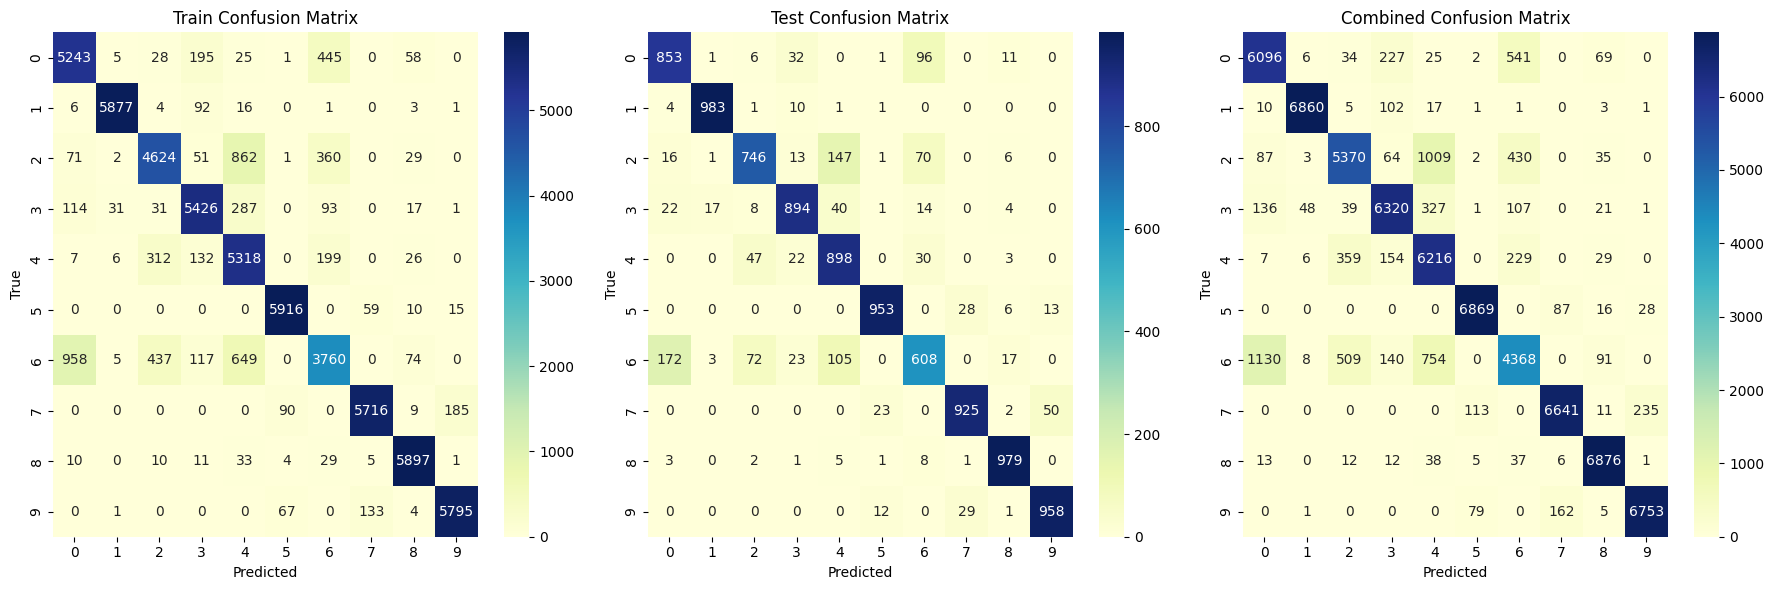

In [71]:
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Function to plot confusion matrix
def MLP_confusion_matrix(ax, cm, labels, title, cmap):
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

# Getting unique class labels
labels = np.unique(y_train)

# Creating confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred, labels=labels)
test_cm = confusion_matrix(y_test, y_test_pred, labels=labels)
all_cm = train_cm + test_cm

# Plotting confusion matrices side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

MLP_confusion_matrix(axs[0], train_cm, labels, title="Train Confusion Matrix", cmap="YlGnBu")
MLP_confusion_matrix(axs[1], test_cm, labels, title="Test Confusion Matrix", cmap="YlGnBu")
MLP_confusion_matrix(axs[2], all_cm, labels, title="Combined Confusion Matrix", cmap="YlGnBu")

plt.tight_layout()
plt.show()

In [72]:

# predicting training and test sets
y_train_pred = mlp_hyper_model.predict(X_train)
y_test_pred = mlp_hyper_model.predict(X_test)

# Precision, Recall, and F1-Score for each class
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)

# Classification Report
report = classification_report(y_test, y_test_pred, target_names=[f'Class {i}' for i in range(10)])

# Macro Average Metrics
macro_precision = precision_score(y_test, y_test_pred, average='macro')
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')

# Micro Average Metrics
micro_precision = precision_score(y_test, y_test_pred, average='micro')
micro_recall = recall_score(y_test, y_test_pred, average='micro')
micro_f1 = f1_score(y_test, y_test_pred, average='micro')

# Print precision, recall, and F1-score for each class
print("Precision for each class:", precision)
print("\nRecall for each class:", recall)
print("\nF1-score for each class:", f1)



Precision for each class: [0.79719626 0.97810945 0.84580499 0.89849246 0.75083612 0.95971803
 0.73607748 0.94099695 0.95140914 0.93829579]

Recall for each class: [0.853 0.983 0.746 0.894 0.898 0.953 0.608 0.925 0.979 0.958]

F1-score for each class: [0.82415459 0.98054863 0.79277365 0.8962406  0.81785064 0.95634722
 0.66593647 0.9329299  0.96500739 0.94804552]


In [73]:
# Print classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      0.85      0.82      1000
     Class 1       0.98      0.98      0.98      1000
     Class 2       0.85      0.75      0.79      1000
     Class 3       0.90      0.89      0.90      1000
     Class 4       0.75      0.90      0.82      1000
     Class 5       0.96      0.95      0.96      1000
     Class 6       0.74      0.61      0.67      1000
     Class 7       0.94      0.93      0.93      1000
     Class 8       0.95      0.98      0.97      1000
     Class 9       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [74]:
# Print macro average metrics
print("Macro Average Precision:", macro_precision)
print("\nMacro Average Recall:", macro_recall)
print("\nMacro Average F1-score:", macro_f1)

Macro Average Precision: 0.8796936665460379

Macro Average Recall: 0.8796999999999999

Macro Average F1-score: 0.8779834609313377


In [76]:
# Print micro average metrics
print("Micro Average Precision:", micro_precision)
print("\nMicro Average Recall:", micro_recall)
print("\nMicro Average F1-score:", micro_f1)

Micro Average Precision: 0.8797

Micro Average Recall: 0.8797

Micro Average F1-score: 0.8796999999999999
